# Actividad PBL 2

### César Isao Pastelin Kohagura - A01659947

### Sophia Gabriela Martínez Albarrán - A01424430

### Luis Emilio Fernández González - A01659517

### Eduardo Botello Casey - A01659281

Se importan librerías para:
- numpy (np): operaciones numéricas y utilidades (p. ej., argmax, redondeo).
- pandas (pd): manejo de datos en DataFrames (carga, filtrado, conteos).
- train_test_split: dividir el dataset aleatoriamente en train/test (reproducible con random_state).

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

- Carga el dataset desde CSV.
- Selecciona solo las columnas relevantes (etiqueta y 5 variables clínicas binarias).
- Renombra a alias cortos para el modelo:
- D=Diabetes_binary, P=HighBP, C=HighChol, F=Smoker, A=HvyAlcoholConsump, DC=DiffWalk.


In [2]:
data = pd.read_csv('diabetes.csv')
data = data[['Diabetes_binary','HighBP','HighChol','Smoker', 'HvyAlcoholConsump','DiffWalk']]
data.rename(columns={"Diabetes_binary":"D","HighBP":"P", "HighChol":"C", "HvyAlcoholConsump":"A", "DiffWalk":"DC", "Smoker":"F"}, inplace=True)

- 6 columnas binarias (0/1): D (objetivo), P, C, F, A, DC.

- Cada fila = una persona; tamaño ≈ 253,680 registros.

- Valores leídos como 0.0/1.0 (float), sin preprocesamiento extra.

- Columnas ordenadas: [D, P, C, F, A, DC]; no existen valores faltantes 

In [3]:
data

,D,P,C,F,A,DC
0,0.0,1.0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
253675,0.0,1.0,1.0,0.0,0.0,0.0
253676,1.0,1.0,1.0,0.0,0.0,1.0
253677,0.0,0.0,0.0,0.0,0.0,0.0
253678,0.0,1.0,0.0,0.0,0.0,0.0


# Dividimos los datos en datos de entrenamiento y prueba 


Separamos el dataset para evaluar el modelo de forma honesta y evitar data leakage: con train estimamos las CPTs y con test validamos predicciones. La división fue aleatoria 80/20 usando train_test_split (test_size=0.2, random_state=42 para reproducibilidad). Luego, en test clasificamos por máxima probabilidad (MAP) y calculamos las métricas (error de diagnóstico).

Tras la división aleatoria 80/20 (random_state=42), las proporciones de la variable objetivo D se mantuvieron prácticamente iguales en ambos conjuntos (desbalance 86/14):

- Entrenamiento: 202,944 filas — D=0: 86.0311 %, D=1: 13.9689 %

- Prueba: 50,736 filas — D=0: 86.2090 %, D=1: 13.7910 %

Esto confirma que el split preserva la distribución de clases y permite evaluar el modelo de forma representativa.

In [4]:
entrenamiento, prueba = train_test_split(data, test_size=0.2, random_state=42)
# Verificar la distribución de la variable objetivo en ambos conjuntos
print("Distribución en entrenamiento:")
print(entrenamiento['D'].value_counts(normalize=True))
print("\nDistribución en prueba:")
print(prueba['D'].value_counts(normalize=True))
print(len(entrenamiento), "en entrenamiento")
print(len(prueba), "en prueba")

Distribución en entrenamiento:
D
0.0    0.860311
1.0    0.139689
Name: proportion, dtype: float64

Distribución en prueba:
D
0.0    0.86209
1.0    0.13791
Name: proportion, dtype: float64
202944 en entrenamiento
50736 en prueba


# Red bayesiana 

Se generó el grafo de la red bayesiana para mejorar la visualización en los cálculos posteriores, las variables se renombraron siendo

A : Alchoholico
F : Fumador
D : Diabetes
P : Presion Alta
DC : Dificultad al caminar
C : Colesterol Alto

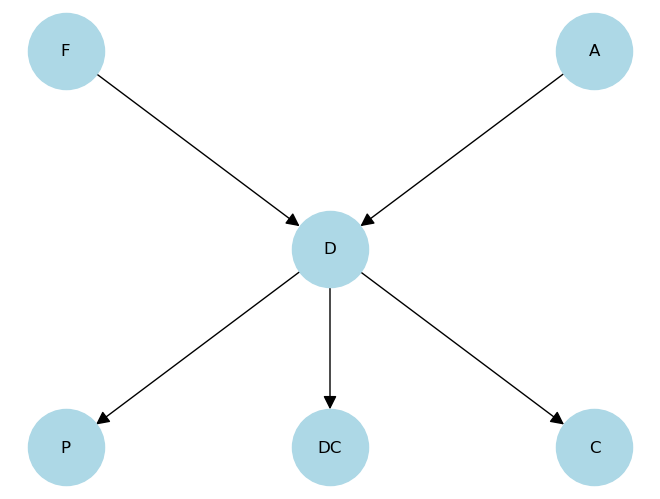

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from([
    ('F','D'), 
    ('A','D'),  
    ('D','P'), 
    ('D','DC'),
    ('D','C')
])

# Posiciones: (x, y)
pos = {
    'F': (-.5, 2),
    'A': (.5, 2),
    'C': (.5, 0),
    'D': (0, 1),
    'P': (-.5, 0),
    'DC': (0, 0)
}

nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', arrowsize=20)
plt.show()


# Calculo de probabilidades con frecuencia

**Probabilidad de fumar y ser alcoholico**

In [6]:
probabilidad_fumar = data.F.sum()/len(entrenamiento)
probabilidad_alcoholico = data.A.sum()/len(entrenamiento)

In [7]:
print("Probailidad fumar", np.round(probabilidad_fumar,4))
print("Probailidad alcoholico", np.round(probabilidad_alcoholico,4))



Probailidad fumar 0.554
Probailidad alcoholico 0.0702



**Probabilidad de diabetes dado fumar y ser alcohólico** 
$$
\text{Sea } F\in\{0,1\} \text{ (fumador) y } A\in\{0,1\} \text{ (alcohólico).}
$$


$$
P(D=1\mid F=f, A=a)\;\approx\;\frac{\#\{D=1,\;F=f,\;A=a\}}{\#\{F=f,\;A=a\}},\qquad f,a\in\{0,1\}.
$$

Además, por complemento:
$$
P(D=0 \mid F=f, A=a) = 1 - P(D=1 \mid F=f, A=a).
$$


In [8]:
fumar_T_alcholico_T = entrenamiento.loc[(entrenamiento.F == 1.0) & (entrenamiento.A == 1.0)]
fumar_T_alcholico_F = entrenamiento.loc[(entrenamiento.F == 1.0) & (entrenamiento.A == 0)]
fumar_F_alcholico_T = entrenamiento.loc[(entrenamiento.F == 0) & (entrenamiento.A == 1.0)]
fumar_F_alcholico_F = entrenamiento.loc[(entrenamiento.F == 0) & (entrenamiento.A == 0)]

**Probabilidad de cada combinación**

Para cada subgrupo definido por F (fumador) y A (alcohólico), la probabilidad de diabetes es la proporción de casos con D=1 dentro del subgrupo:

$$
\hat P(D=1\mid F=f, A=a)=\frac{\#\{D=1, F=f, A=a\}}{\#\{F=f, A=a\}},\quad f,a\in\{0,1\}.
$$

In [ ]:
probabilidad_diabetes_fumar_T_alcholico_T = fumar_T_alcholico_T.D.sum()/len(fumar_T_alcholico_T)
probabilidad_diabetes_fumar_T_alcholico_F = fumar_T_alcholico_F.D.sum()/len(fumar_T_alcholico_F)
probabilidad_diabetes_fumar_F_alcholico_T = fumar_F_alcholico_T.D.sum()/len(fumar_F_alcholico_T)
probabilidad_diabetes_fumar_F_alcholico_F = fumar_F_alcholico_F.D.sum()/len(fumar_F_alcholico_F)

**P(D) por combinaciones de F (fumador) y A (alcohólico)**  

La tabla muestra la **probabilidad condicional estimada de diabetes** para cada combinación de hábitos.  
Se calcula en *entrenamiento* como proporción dentro de cada subgrupo (T=1, F=0):

$$
\hat P(D=1 \mid F=f, A=a)=\frac{\#\{D=1,\;F=f,\;A=a\}}{\#\{F=f,\;A=a\}},\quad f,a\in\{0,1\}.
$$

Los valores impresos (p. ej., 0.0683 para \(F{=}1, A{=}1\)) son esas estimaciones y constituyen la **CPT** usada por la red bayesiana.


In [10]:
print("F  A  | P(D)")
print("--------------")
print("T  T  |",np.round(probabilidad_diabetes_fumar_T_alcholico_T,4))
print("T  F  |",np.round(probabilidad_diabetes_fumar_T_alcholico_F,4))
print("F  T  |",np.round(probabilidad_diabetes_fumar_F_alcholico_T,4))
print("F  F  |",np.round(probabilidad_diabetes_fumar_F_alcholico_F,4))



F  A  | P(D)
--------------
T  T  | 0.0683
T  F  | 0.1725
F  T  | 0.0454
F  F  | 0.1232



**Cálculo de la probabilidad total de tener diabetes**

Estimamos la prevalencia global \(P(D=1)\) aplicando la **ley de la probabilidad total** sobre todas las combinaciones de hábitos \(F\) (fumador) y \(A\) (alcohólico), usando las CPTs \(P(D=1 \,|\, F, A)\) y las marginales \(P(F)\) y \(P(A)\) calculadas en entrenamiento.  
En el código se asume independencia entre \(F\) y \(A\), por lo que \(P(F=f, A=a)=P(F=f)\,P(A=a)\).

$$
\hat P(D=1)\;\approx\;\sum_{f\in\{0,1\}}\sum_{a\in\{0,1\}}
\hat P(D=1\mid F=f,A=a)\;\hat P(F=f)\;\hat P(A=a).
$$



In [11]:
probabilidad_diabetes = probabilidad_diabetes_fumar_T_alcholico_T * probabilidad_fumar * probabilidad_alcoholico + \
                        probabilidad_diabetes_fumar_T_alcholico_F * probabilidad_fumar * (1 - probabilidad_alcoholico) + \
                        probabilidad_diabetes_fumar_F_alcholico_T * (1 - probabilidad_fumar) * probabilidad_alcoholico + \
                        probabilidad_diabetes_fumar_F_alcholico_F * (1 - probabilidad_fumar) * (1 - probabilidad_alcoholico) 
                        
                        

In [12]:
print("Probabilidad diabetes", np.round(probabilidad_diabetes,4))

Probabilidad diabetes 0.144


**Probabilidad de los síntomas dado la diabetes** 

Primero se separa el dataset en:
- `diabetes_T`: casos con \(D=1\),
- `diabetes_F`: casos con \(D=0\).

Para cada síntoma $X$ en $\{P, C, DC\}$: 

$$
P(X=1 \,|\, D=d) \approx \frac{\#\{X=1,\; D=d\}}{\#\{D=d\}}, \quad d\in\{0,1\}.
$$



In [13]:
diabetes_T = data.loc[(data.D == 1.0)]
diabetes_F = data.loc[(data.D == 0)]

**Probabilidades condicionales dadas las frecuencias**

Se separan los registros en dos grupos: `diabetes_T` (D=1) y `diabetes_F` (D=0).  
Para cada síntoma X ∈ {P, C, DC}, la probabilidad condicional se estima como proporción en cada grupo:

$$
P(X=1 \;|\; D=d) \approx \frac{\#\{X=1,\; D=d\}}{\#\{D=d\}}, \quad d \in \{0,1\}.
$$


In [14]:
probabilidad_diabetes_T_presion_T = diabetes_T.P.sum()/len(diabetes_T)
probabilidad_diabetes_F_presion_T = diabetes_F.P.sum()/len(diabetes_F)

probabilidad_diabetes_T_colesterol_T = diabetes_T.C.sum()/len(diabetes_T)
probabilidad_diabetes_F_colesterol_T = diabetes_F.C.sum()/len(diabetes_F)

probabilidad_diabetes_T_diffcaminar_T = diabetes_T.DC.sum()/len(diabetes_T)
probabilidad_diabetes_F_diffcaminar_T = diabetes_F.DC.sum()/len(diabetes_F)



**Probabilidades de síntomas dado el estado de diabetes**

La tabla muestra, para cada estado de \(D\) (T=1, F=0), la probabilidad de que cada síntoma valga 1:
- `P(P)` = \(P(P=1 \,|\, D=d)\)
- `P(C)` = \(P(C=1 \,|\, D=d)\)
- `P(DC)` = \(P(DC=1 \,|\, D=d)\)

Se estiman en entrenamiento por frecuencia:
$$
P(X=1 \,|\, D=d) \approx \frac{\#\{X=1,\; D=d\}}{\#\{D=d\}},
\quad X \in \{P, C, DC\},\; d \in \{0,1\}.
$$



In [15]:
print("D  |  P(P)  |  P(C)  |  P(DC) ")
print("------------------------------")
print("T  |",np.round(probabilidad_diabetes_T_presion_T,4),'|',np.round(probabilidad_diabetes_T_colesterol_T,4),'|',np.round(probabilidad_diabetes_T_diffcaminar_T,4))
print("F  |",np.round(probabilidad_diabetes_F_presion_T,4),'|',np.round(probabilidad_diabetes_F_colesterol_T,4),'|',np.round(probabilidad_diabetes_F_diffcaminar_T,4))




D  |  P(P)  |  P(C)  |  P(DC) 
------------------------------
T  | 0.7527 | 0.6701 | 0.3712
F  | 0.3766 | 0.3843 | 0.1354


**Probabilidad general de cada síntoma**

Se aplica la **ley de la probabilidad total** sobre \(D\).  
Para cualquier síntoma \(X\) en {P, C, DC}:

$$
P(X=1) = P(X=1 \mid D=1)\,P(D=1) + P(X=1 \mid D=0)\,P(D=0).
$$


In [16]:
probabilidad_presion = probabilidad_diabetes_T_presion_T * probabilidad_diabetes + probabilidad_diabetes_F_presion_T * (1 - probabilidad_diabetes)
probabilidad_colesterol = probabilidad_diabetes_T_colesterol_T * probabilidad_diabetes + probabilidad_diabetes_F_colesterol_T * (1 - probabilidad_diabetes)
probabilidad_diffcaminar = probabilidad_diabetes_T_diffcaminar_T * probabilidad_diabetes + probabilidad_diabetes_F_diffcaminar_T * (1 - probabilidad_diabetes)



In [17]:
print("Probabilidad presion alta", np.round(probabilidad_presion,4))
print("Probabilidad colesterol alto", np.round(probabilidad_colesterol,4))
print("Probabilidad dificultad para caminar", np.round(probabilidad_diffcaminar,4))


Probabilidad presion alta 0.4308
Probabilidad colesterol alto 0.4255
Probabilidad dificultad para caminar 0.1693


# Calculo del error de diagnóstico 

**Probabilidad condicional y probabilidad conjunta para obtener D**


$$
P(D \mid A, F, C, P, DC ) = \frac{P(D, A, F, C, P, DC)}{P(A,F, C, P,DC)} = \frac{P(D\mid A , F) P(C \mid D )P(P \mid D )P(DC \mid D )P(A)P(F)}{P(A)P(F)P(C)P(P)P(DC)} 
$$

$$
= \frac{P(D\mid A , F) P(C \mid D )P(P \mid D )P(DC \mid D )}{P(C)P(P)P(DC)}
$$

Se crean diccionarios con probabilidades estimadas, esto para facilitar la prediccion de la diabetes:
  - `p_D_dado_F_A[(d,f,a)]` → \(P(D=d \,|\, F=f, A=a)\)
  - `p_C_dado_D[(d,c)]`      → \(P(C=c \,|\, D=d)\)
  - `p_C_dado_P[(d,p)]`      → \(P(P=p \,|\, D=d)\)
  - `p_C_dado_DC[(d,dc)]`    → \(P(DC=dc \,|\, D=d)\)

Se crean vectores de probabilidad para los sintomas C, P y DC, ya que estas probabilidades son los denominadores.

- **Predicción en test (regla MAP, sin umbral)**:
  1) Para cada fila de prueba, se extraen \(F,A,P,C,DC\) y se guarda la etiqueta real D en y_real.
  2) Se calculan dos scores, uno por cada hipótesis D = 1 y D = 0, esto se calcula con los datos que se extrajeron en el paso 1.
  3) Se clasifica por máxima probabilidad (MAP): Se elige la clase con mayor score (con el metodo de `np.argmax`, que selecciona el indice con mayor valor, el indice 0 es Falso y el 1 es Verdadero) y se añade a y_pred.


In [ ]:
p_D_dado_F_A = {
    # (Diabetes, Fumar, Alcoholico)
    (1,1,1) : probabilidad_diabetes_fumar_T_alcholico_T,
    (0,1,1) : 1 - probabilidad_diabetes_fumar_T_alcholico_T,
    
    (1,1,0) : probabilidad_diabetes_fumar_T_alcholico_F,
    (0,1,0) : 1- probabilidad_diabetes_fumar_T_alcholico_F,
    
    (1,0,1) : probabilidad_diabetes_fumar_F_alcholico_T,
    (0,0,1) : 1 - probabilidad_diabetes_fumar_F_alcholico_T,
    
    (1,0,0) : probabilidad_diabetes_fumar_F_alcholico_F,
    (0,0,0) : 1 - probabilidad_diabetes_fumar_F_alcholico_F
}

p_C_dado_D = {
    # (Diabetes, Colesterol)
    (1,1) : probabilidad_diabetes_T_colesterol_T,
    (1,0) : 1 - probabilidad_diabetes_T_colesterol_T,
    (0,1) : probabilidad_diabetes_F_colesterol_T,
    (0,0) : 1 - probabilidad_diabetes_F_colesterol_T
}

p_C_dado_P = {
    # (Diabetes, Presion alta)
    (1,1) : probabilidad_diabetes_T_presion_T,
    (1,0) : 1 - probabilidad_diabetes_T_presion_T,
    (0,1) : probabilidad_diabetes_F_presion_T,
    (0,0) : 1 - probabilidad_diabetes_F_presion_T
}

p_C_dado_DC = {
    # (Diabetes, Dificuldad Caminar)
    (1,1) : probabilidad_diabetes_T_diffcaminar_T,
    (1,0) : 1 - probabilidad_diabetes_T_diffcaminar_T,
    (0,1) : probabilidad_diabetes_F_diffcaminar_T,
    (0,0) : 1 - probabilidad_diabetes_F_diffcaminar_T
}


probabilidad_fumar_vector = [1-probabilidad_fumar, probabilidad_fumar]
probabilidad_alcoholico_vector = [1-probabilidad_alcoholico, probabilidad_alcoholico]

probabilidad_diabetes_vector = [1-probabilidad_diabetes, probabilidad_diabetes]

probabilidad_presion_vector = [1-probabilidad_presion, probabilidad_presion]
probabilidad_colesterol_vector = [1-probabilidad_colesterol, probabilidad_colesterol]
probabilidad_diffcaminar_vector = [1-probabilidad_diffcaminar, probabilidad_diffcaminar]

y_real = []
y_pred = []

# Iterar en las filas del dataframe de prueba
for index, row in prueba.iterrows():
    F = int(row['F'])
    A = int(row['A'])
    D = int(row['D'])
    P = int(row['P'])
    C = int(row['C'])
    DC = int(row['DC'])
    
    y_real.append(D)
    
    resultado_provisional = []
    for posible_D in [0,1]:
        
        total = (p_D_dado_F_A[(posible_D,F,A)] * p_C_dado_D[(posible_D,C)] * p_C_dado_P[(posible_D,P)] * p_C_dado_DC[(posible_D,DC)]) / (probabilidad_presion_vector[P] * probabilidad_colesterol_vector[C] * probabilidad_diffcaminar_vector[DC])
        resultado_provisional.append(total)

    # Predecir la clase con mayor probabilidad
    prediccion = np.argmax(resultado_provisional)
    y_pred.append(prediccion)

Al ya tener los datos predichos y los datos reales, corremos la validacion con la libreria de sklearn, donde nos va a dar la matriz de confusion y en las diferentes metricas como nuestra red puntuo. 

# Evaluación

**Cómo se evaluó**
1) **Split 80/20** (`random_state=42`).  
2) Con **train** se estimaron por **frecuencias** las CPTs: `P(D|F,A)`, `P(P|D)`, `P(C|D)`, `P(DC|D)`.   
3) En **test**, para cada persona se calcularon dos *scores* (D=0 y D=1) y se **clasificó por máxima probabilidad (MAP)**: se eligió la clase con mayor score.  
4) Se midieron **accuracy**, **reporte de clasificación** y **matriz de confusión** con `sklearn`.

**Resultados (test)**
- **Accuracy:** `0.8512`  → **error de diagnóstico:** `0.1488`.  
- **Matriz de confusión:** TN=41,588; FP=2,151; FN=5,396; TP=1,601.
- **Reporte por clase:**
  - Clase 0 (no diabetes): **precision 0.89**, **recall 0.95**, **F1 0.92** .
  - Clase 1 (diabetes): **precision 0.43**, **recall 0.23**, **F1 0.30** .

- El modelo es **muy específico** (identifica bien sanos), pero tiene **baja sensibilidad** para diabetes (muchos FN).

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_real, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_real, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_real, y_pred))

Accuracy: 0.8512

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     43739
           1       0.43      0.23      0.30      6997

    accuracy                           0.85     50736
   macro avg       0.66      0.59      0.61     50736
weighted avg       0.82      0.85      0.83     50736


Confusion Matrix:
[[41588  2151]
 [ 5396  1601]]
